# SP500 agrupación por sectores: Análisis con K-Means

Este notebook es el soporte del artículo: https://estrategiastrading.com/k-means-con-python
<br>La idea es ver cómo se agrupan las acciones del SP500 si utilizamos un método de aprendisaje no supervisado (en este caso K-Means). ¿Es este agrupamiento similar al utilizado cuando se clasifican las acciones por sectores GICS?<br> 
Aviso: Estoy utilizando los datos desde yahoo con la lista de tickers del sp500 a día de hoy. No estoy teniendo en cuenta las acciones deslistadas. Este ejercicio es simplemente una prueba de concepto para aplicar K-Means y no divido los datos en train/ test set

## 1. Cargar paquetes y datos

In [1]:
# Importo paquetes y configuración
import numpy as np
import pandas as pd
import seaborn as sns
# configuración gráficos
import matplotlib.pyplot as plt
%matplotlib inline
# customizaciones
plt.rcParams['figure.figsize']= 12,6

# Importaciones de K-Means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


---
## 2. Cargar, limpiar y trabajar data

In [2]:
#Tomo la info sobre las acciones y la clasificación x sectores de la tabla wikipedia
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', header =0, flavor = 'bs4')[0]
table.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added[3][4],CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
# Solo quiero los tickers, nombres y sector
table = table.loc[:,['Symbol','Security','GICS Sector']].set_index('Symbol')
table.head()

,Security,GICS Sector
Symbol,,
MMM,3M Company,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie Inc.,Health Care
ABMD,ABIOMED Inc,Health Care
ACN,Accenture plc,Information Technology


In [4]:
#Esta es la lista de tickers 
tickers = table.index.values.tolist()

In [5]:
'''Los datos vienen desde Yahoo desde 2016
están guardados en el repositorio data para poder replicar el análisis'''
url = 'https://raw.githubusercontent.com/Duk2/Data/master/precios_cierre_acciones_SP500.csv'
cierres = pd.read_csv(url,index_col='Date', parse_dates=True)
cierres.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,40.611141,41.126011,149.708435,99.840477,52.961937,98.492264,90.279999,42.043522,98.625694,93.940002,...,32.585835,43.879574,69.643501,59.610352,26.030481,35.113663,49.111866,100.044907,26.234152,46.901539
2016-01-04,39.523247,39.727627,151.429276,99.925850,51.504684,96.744843,85.239998,40.189907,96.105782,91.970001,...,32.395283,42.786564,69.205704,57.660900,25.222389,34.709618,48.547131,99.284256,25.667187,46.265354
2016-01-05,39.387260,39.348907,150.394806,97.421768,51.290115,98.159882,85.000000,40.180538,96.605988,92.339996,...,32.721958,43.421818,69.795372,58.836452,25.173414,34.699997,48.426121,101.351677,25.388510,46.989624
2016-01-06,39.562099,40.038387,146.416092,95.515244,51.299061,96.659370,85.300003,39.843513,96.417236,91.019997,...,33.066780,42.627747,69.214653,57.984173,24.855070,34.267082,48.083248,101.790497,24.648573,46.999409
2016-01-07,37.881710,39.280922,148.037415,91.484085,51.147072,93.572876,81.919998,38.888622,93.585876,89.110001,...,33.193821,40.946178,68.106796,57.474762,24.169415,33.382030,46.442814,99.450035,23.908636,45.570442


In [6]:
# Controlo cuantos datos tengos (filas, columnas)
cierres.shape

(756, 503)

### 2.2. Limpieza y formateo

In [7]:
# Returns & Volat
returns = cierres.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = cierres.pct_change().std() * np.sqrt(252)
returns.head()

,Returns,Volatility
A,0.186725,0.228322
AAL,-0.015866,0.354138
AAP,0.073412,0.332808
AAPL,0.181026,0.236480
ABBV,0.212363,0.276692


In [8]:
#checkeo si hay vacios
print(returns.isnull().sum())

Returns       0
Volatility    0
dtype: int64


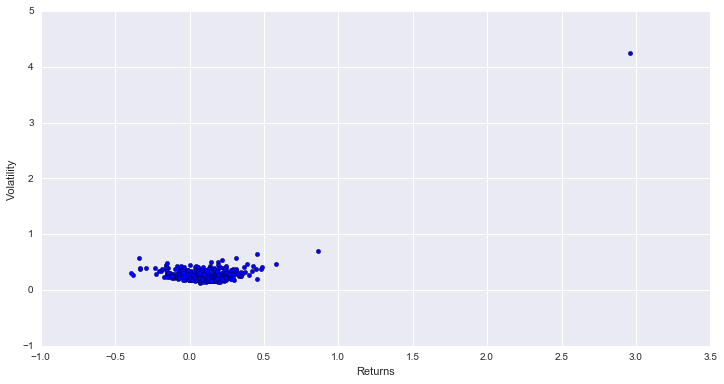

In [9]:
#Exploratory data analisis first: visualizar los datos
plt.scatter(returns['Returns'], returns['Volatility'])
plt.xlabel('Returns')
plt.ylabel('Volatility');

Hay un outlier, vamos a mirarlo y ver que hacer con él

In [10]:
print(returns.idxmax())

Returns       BHF
Volatility    BHF
dtype: object


El outlier corresponde a BHF q comienza a tener datos en Yahoo en julio 2017 (antes esta todo a ceros). Lo quito de Returns y también de la tabla inicial porque afecta al resto

In [11]:
returns.drop('BHF',inplace=True)()

TypeError: 'NoneType' object is not callable

In [12]:
table.drop('BHF', inplace=True)

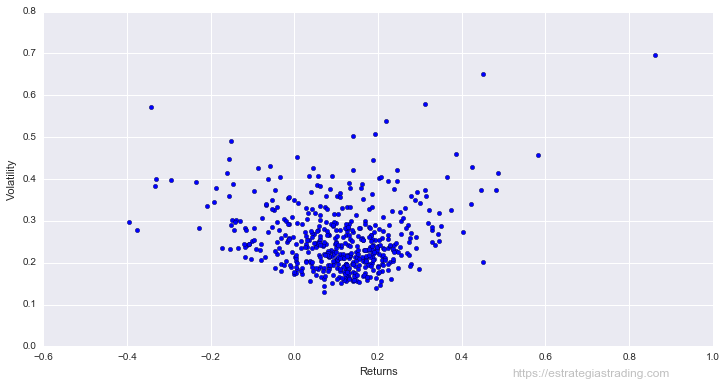

In [13]:
# Grafico de dispersión previo a clustering
fig, ax = plt.subplots()
ax.scatter(returns['Returns'], returns['Volatility'])
ax.set_xlabel('Returns')
ax.set_ylabel('Volatility')
fig.text(0.85, 0.05, 'https://estrategiastrading.com',
         fontsize=12, color='gray',
         ha='right', va='bottom', alpha=0.5)
plt.savefig('Grafico de dispersión.png');


---
## 3. K-Means


In [14]:
# Tengo que formatear como numpy array para utilizar KMeans
data_v0 = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T
data_v0

array([[ 0.18672494,  0.22832194],
       [-0.01586589,  0.35413833],
       [ 0.07341228,  0.33280751],
       ...,
       [ 0.03326184,  0.22624288],
       [ 0.19138251,  0.27388436],
       [ 0.21754817,  0.20563058]])

 ---
### 3.1 Datos normalizados
En el algoritmo KMean la varianza de un feature se corresponde con su influencia en el agrupamiento<br>
Para que todos los elementos sean tratados por igual, es necesario transformar e igualar las varianzas <br>

### 3.1.2 Pruebo con Scale como preproceso

StandardScaler transforma cada feature para que tenga una media de cero y una varianza de 1

In [15]:
scaler = StandardScaler()
scaler.fit(data_v0)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
data_scaled= scaler.transform(data_v0)
data_scaled

array([[ 0.59194221, -0.38385704],
       [-0.91112231,  1.22343012],
       [-0.24874856,  0.95093176],
       ...,
       [-0.54663319, -0.41041672],
       [ 0.62649772,  0.19819658],
       [ 0.82062632, -0.6737361 ]])

---
### 3.2 Nº clusters
Miramos cuál es el mejor número de k (clusters) en los que debemos agrupar los datos.<br> 
Teoría: Existen varios métodos para seleccionar el numéro óptimo de clústers, aquí testeamos el "método del codo" donde la calidad del agrupamiento se mide con la inercia. La inercia mide qué tan dispersos están los clusters (cuánto más bajo mejor).  La inercia es la suma de las distancias al cuadrado de cada objeto del Cluster a su centroide.

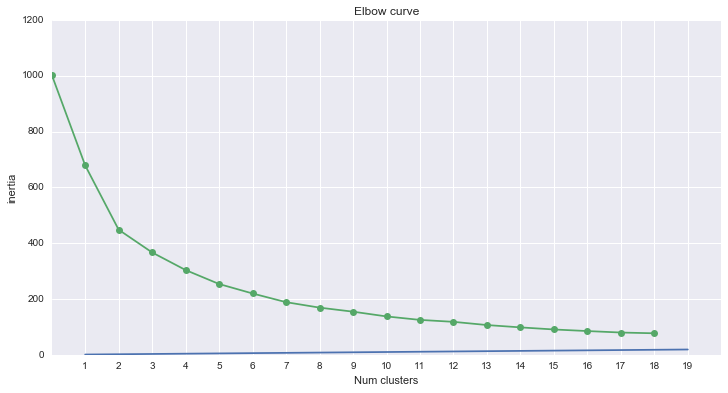

In [17]:
#Elbow curve
ks = range (1,20) # cantidad de clusters a testear
x = data_scaled

inertias=[]
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(x)
    inertias.append(model.inertia_)
    
plt.plot(range(1, 20),ks, inertias, '-o')
plt.xlabel('Num clusters')
plt.ylabel('inertia')
plt.xticks(ks)
plt.grid(True)
plt.title('Elbow curve');

No veo un "codo" muy claro ¿Probamos con 4 clusters?

In [18]:
model = KMeans(n_clusters=4)
model.fit(data_scaled)
print(model.inertia_)

366.8310935506606


In [19]:
model = KMeans(n_clusters=3)
model.fit(data_scaled)
print(model.inertia_)

448.3986544517767


---
### 3.3. Gráfico clústers

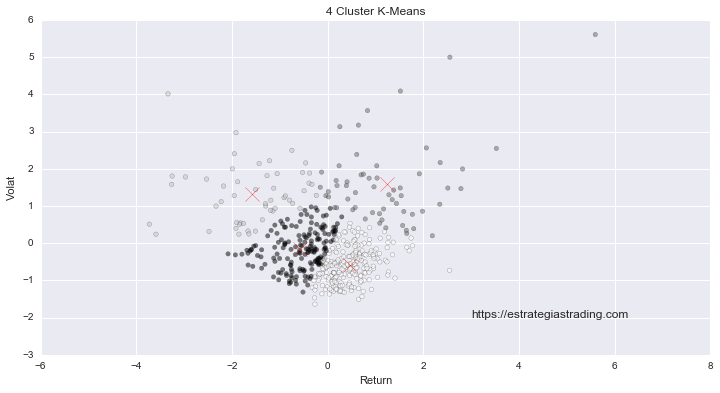

In [24]:
kmeans= KMeans(n_clusters=4,init='k-means++',max_iter=1000)
kmeansoutput=kmeans.fit(data_scaled)
centroides = kmeans.cluster_centers_
labels = kmeans.predict(data_scaled)
plt.scatter(data_scaled[:, 0], data_scaled[:, 1],c=labels,alpha= 0.5)
plt.scatter(centroides[:,0],centroides[:,1], c='red',marker= 'x', s=200)
plt.xlabel('Return')
plt.ylabel('Volat')
plt.title('4 Cluster K-Means')
plt.text(3, -2, 'https://estrategiastrading.com', fontsize=12)
plt.savefig('4 Clusters K-Means.png');

In [25]:
centroides
#Al relanzar K Means el orden del array de los centroides cambia, pero los centroides son los mismos

array([[ 0.46912177, -0.59226476],
       [-1.59178488,  1.31605893],
       [ 1.23015021,  1.58091891],
       [-0.56976239, -0.15209959]])

In [31]:
# convierto a df
clustering = pd.DataFrame({'Ticker':returns.index,'Cluster':labels}).set_index('Ticker')
clustering.head()

,Cluster
Ticker,
A,0
AAL,1
AAP,3
AAPL,0
ABBV,0


---
## 4. ¿Cómo quedan agrupadas las acciones?

No es lo mismo con los datos pasados por StandarScaler que en normal <br>
Agrupo todos los dos datos que he obtenido en una sola tabla

In [32]:
clustering_results = pd.concat([clustering,table,returns], axis=1)
clustering_results.head()

,Cluster,Security,GICS Sector,Returns,Volatility
A,0.0,Agilent Technologies Inc,Health Care,0.186725,0.228322
AAL,1.0,American Airlines Group,Industrials,-0.015866,0.354138
AAP,3.0,Advance Auto Parts,Consumer Discretionary,0.073412,0.332808
AAPL,0.0,Apple Inc.,Information Technology,0.181026,0.236480
ABBV,0.0,AbbVie Inc.,Health Care,0.212363,0.276692


### 4.1 Gráficos por sectores GICS

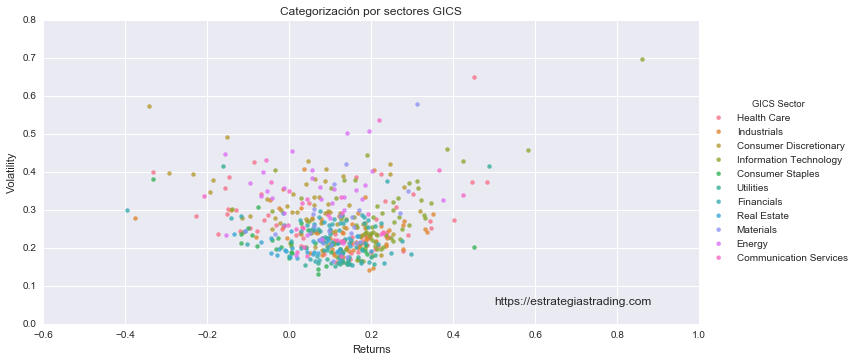

In [33]:
sns.lmplot(x='Returns', y='Volatility', data= clustering_results,fit_reg=False, hue='GICS Sector', size=5, aspect=2)
plt.title('Categorización por sectores GICS')
plt.text(0.5, 0.05, 'https://estrategiastrading.com', fontsize=12)
plt.savefig('ScatterPlot_por_sectores.png');

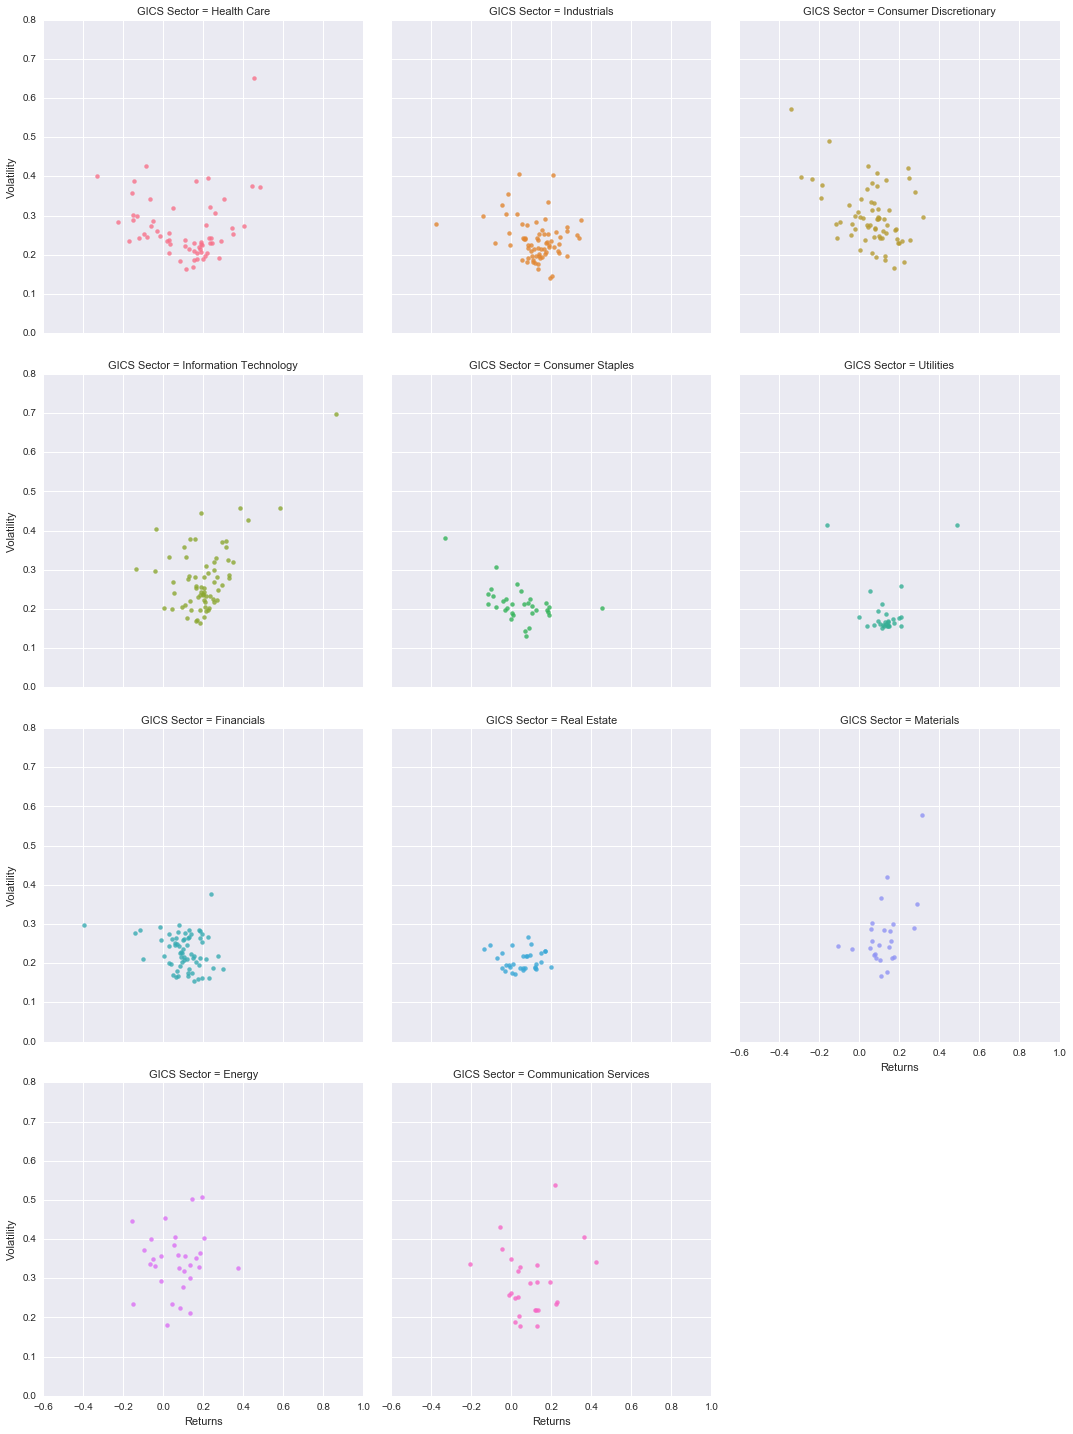

In [34]:
sns.lmplot(x='Returns', y='Volatility', data= clustering_results,fit_reg=False, col='GICS Sector',hue='GICS Sector', col_wrap=3)
plt.savefig('ScatterPlot_individual_por_sectores.png');

### 4.2 Gráficos por clustering inicial 

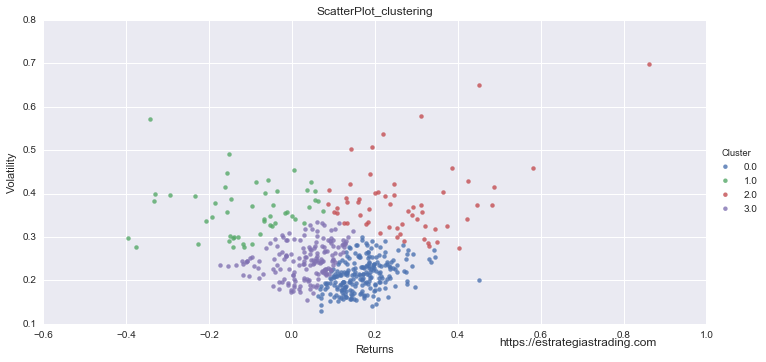

In [35]:
sns.lmplot(x='Returns', y='Volatility', data= clustering_results,fit_reg=False, hue='Cluster', size=5, aspect=2)
plt.title('ScatterPlot_clustering')
plt.text(0.5, 0.05, 'https://estrategiastrading.com', fontsize=12)
plt.savefig('ScatterPlot_clustering.png');

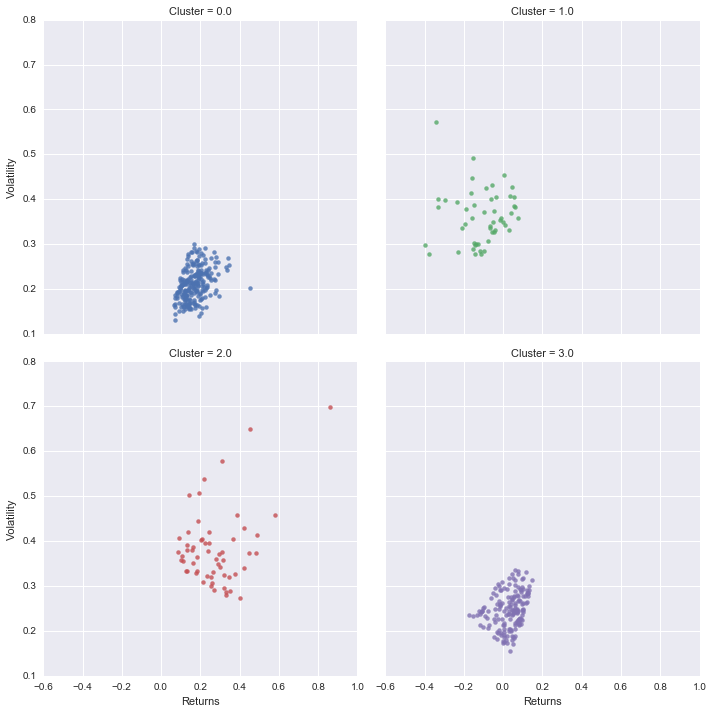

In [37]:
sns.lmplot(x='Returns', y='Volatility', data= clustering_results,fit_reg=False, col='Cluster', hue='Cluster',col_wrap=2)
plt.savefig('ScatterPlot_individual_clustering.png');

### 4.3 Grafico sectores por clustering

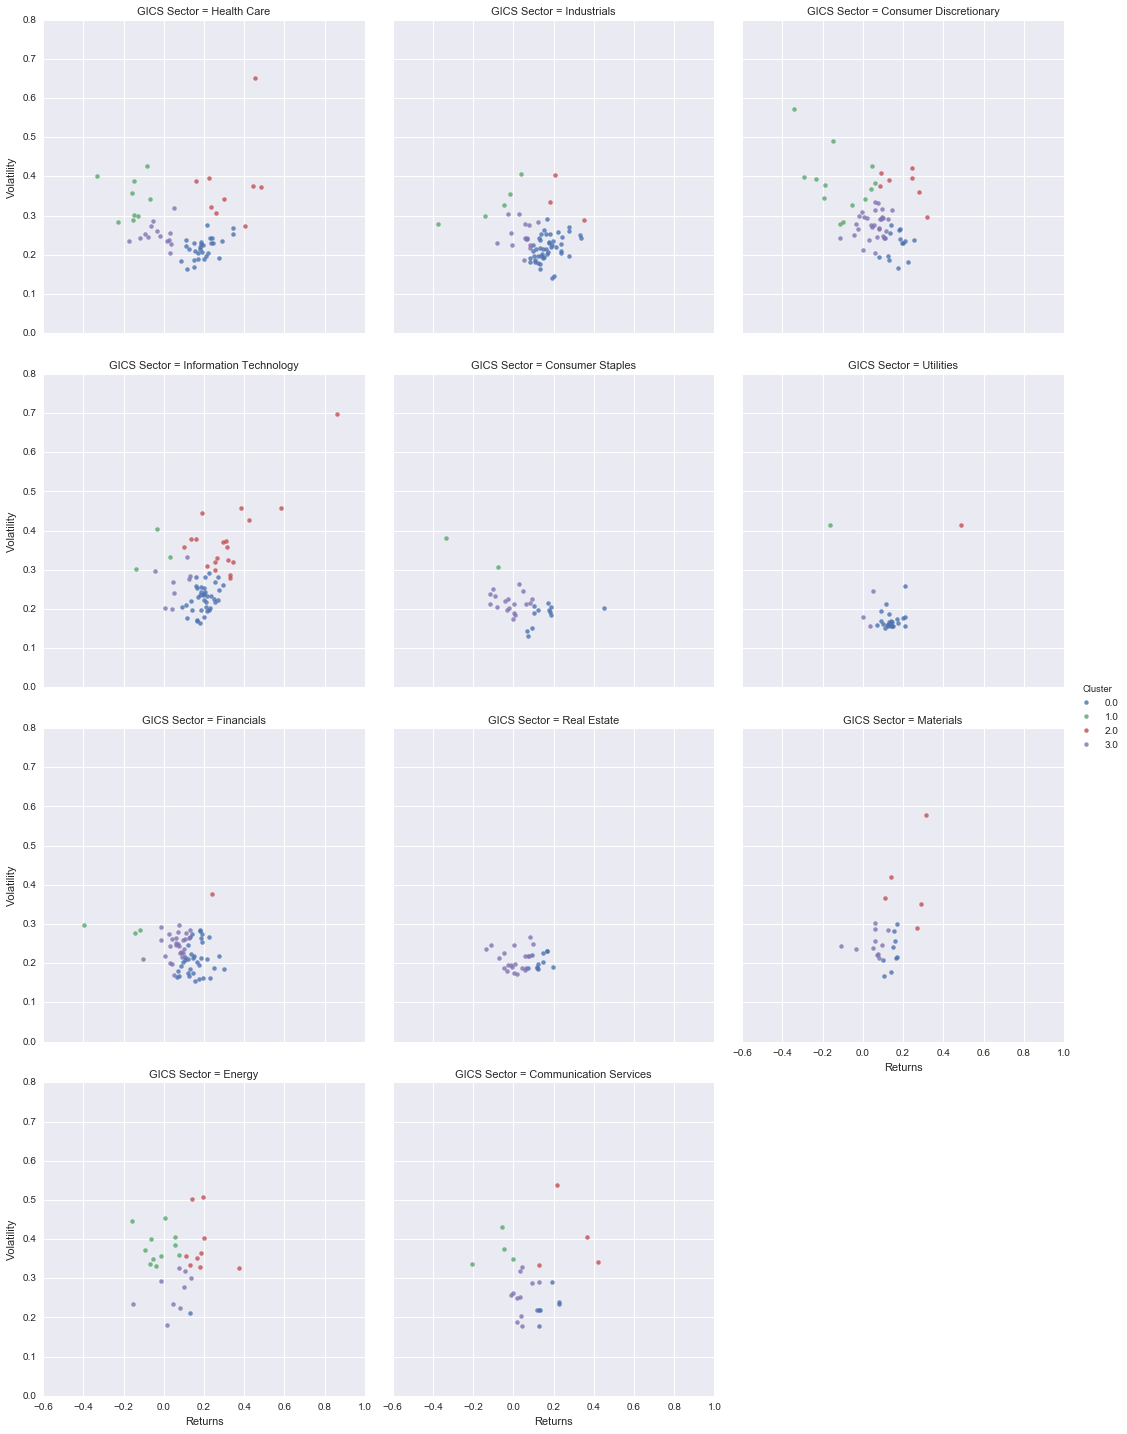

In [38]:
sns.lmplot(x='Returns', y='Volatility', data= clustering_results,fit_reg=False, col='GICS Sector',hue='Cluster', col_wrap=3)
plt.savefig('ScatterPlot_individual_por_sectores_y_clustering.png');

---
## 5. Igual número de clusters que de sectores

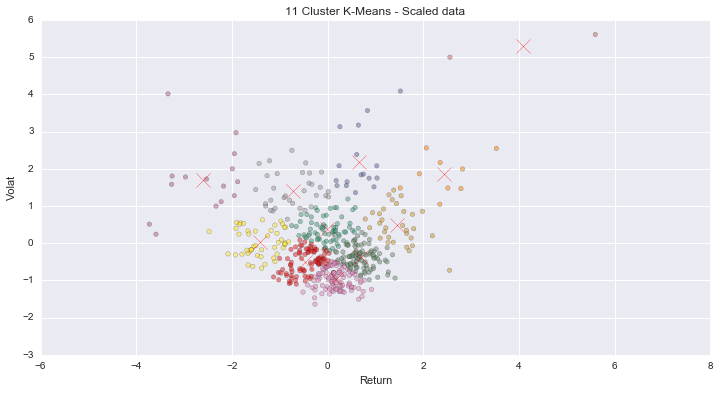

In [39]:
# Tengo 11 sectores GICS pruebo entonces 11 clusters
kmeans= KMeans(n_clusters=11,init='k-means++',max_iter=1000)
kmeansoutput_11=kmeans.fit(data_scaled)
centroides_11 = kmeans.cluster_centers_
labels_11= kmeans.predict(data_scaled)
plt.scatter(data_scaled[:, 0], data_scaled[:, 1],c=labels_11,cmap= 'Set1',alpha= 0.5)
plt.scatter(centroides_11[:,0],centroides_11[:,1], c='red',marker= 'x', s=200)
plt.xlabel('Return')
plt.ylabel('Volat')
plt.title('11 Cluster K-Means - Scaled data')
plt.savefig('11_Cluster_K-Means.png');

In [40]:
# ¿Cuanta inercia tengo con 11 clusters?
model = KMeans(n_clusters=11)
model.fit(data_scaled)
print(model.inertia_)

138.558263423026


### 5.1 Comparo la clasificación por sectores con el clustering de K-Means

In [41]:
# Primero añado los resultados del clustering al df
clustering_11 = pd.DataFrame({'Ticker':returns.index,'11_Clusters':labels_11}).set_index('Ticker')
clustering_11.head()

,11_Clusters
Ticker,
A,3
AAL,10
AAP,2
AAPL,3
ABBV,3


In [42]:
clustering_results_all = pd.concat([table,returns,clustering,clustering_11], axis=1).sort_values(by=['GICS Sector','Cluster','11_Clusters'])
clustering_results_all

,Security,GICS Sector,Returns,Volatility,Cluster,11_Clusters
CHTR,Charter Communications,Communication Services,0.193109,0.289851,0.0,2.0
FOX,Twenty-First Century Fox Class B,Communication Services,0.224767,0.235567,0.0,3.0
FOXA,Twenty-First Century Fox Class A,Communication Services,0.228564,0.238747,0.0,3.0
CMCSA,Comcast Corp.,Communication Services,0.117273,0.220051,0.0,9.0
GOOG,Alphabet Inc Class C,Communication Services,0.130921,0.218075,0.0,9.0
GOOGL,Alphabet Inc Class A,Communication Services,0.125477,0.218355,0.0,9.0
VZ,Verizon Communications,Communication Services,0.126162,0.178684,0.0,9.0
DISH,Dish Network,Communication Services,-0.207734,0.336425,1.0,4.0
CTL,CenturyLink Inc,Communication Services,-0.000684,0.348960,1.0,10.0
TRIP,TripAdvisor,Communication Services,-0.057043,0.431954,1.0,10.0


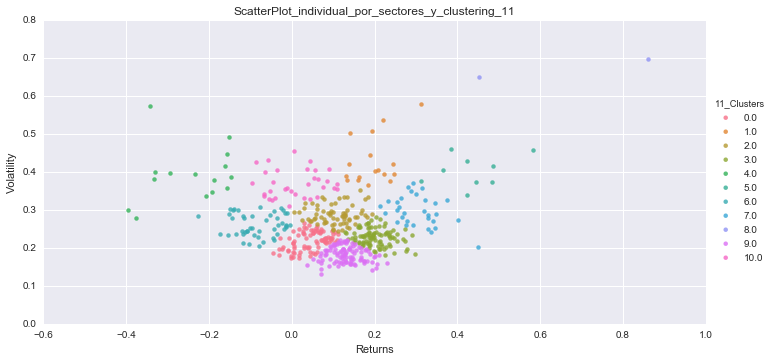

In [44]:
sns.lmplot(x='Returns', y='Volatility', data= clustering_results_all,fit_reg=False,hue='11_Clusters', size=5, aspect=2)
plt.title('ScatterPlot_individual_por_sectores_y_clustering_11')
plt.savefig('ScatterPlot_clustering_11.png');

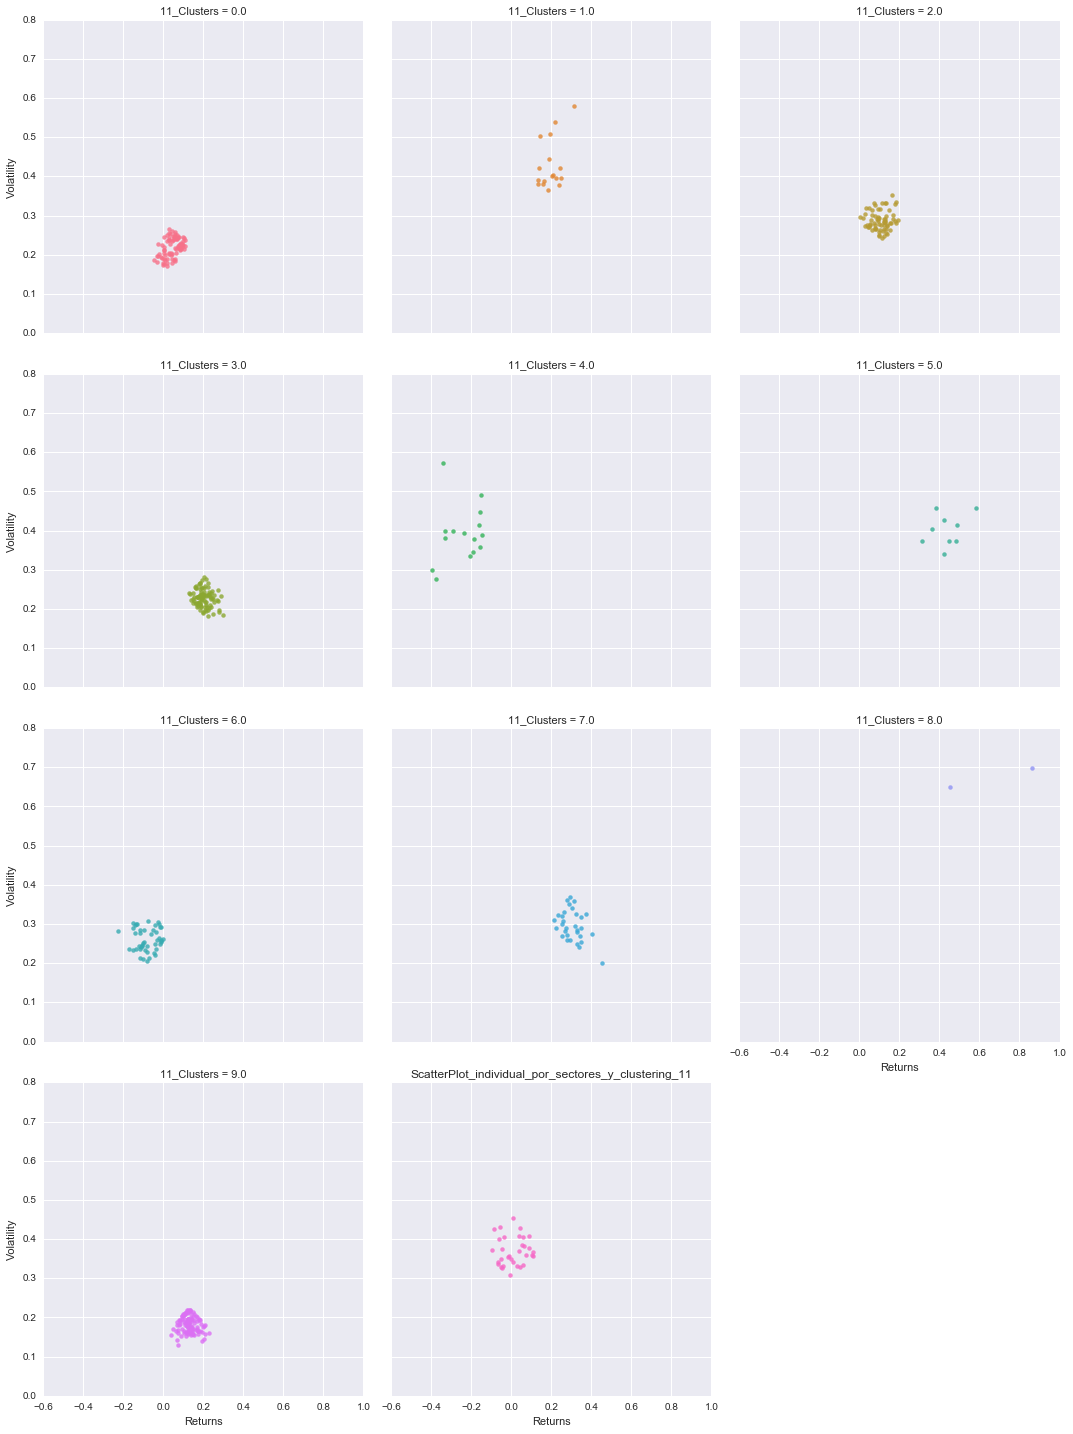

In [45]:
sns.lmplot(x='Returns', y='Volatility', data= clustering_results_all,fit_reg=False, col='11_Clusters',hue='11_Clusters', col_wrap=3)
plt.title('ScatterPlot_individual_por_sectores_y_clustering_11')
plt.savefig('ScatterPlot_individual_por_sectores_y_clustering_11.png');